# Multinomial Naive Bayes

A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class. More formally, if I want to calculate the probability of observing features $ F_1 ... F_n $, given some class c, under the Naive Bayes assumption the following holds:

$$ P(f_1,...,f_n|c)=\prod_{i=1}^{n} P(f_i|c) $$

This means that when I want to use a Naive Bayes model to classify a new example, the posterior probability is much simpler to work with:

$$ P(c|f_1,...,f_n) ∝ P(c)P(f_1|c)...P(f_n|c) $$

Of course these assumptions of independence are rarely true, but in practice Naive Bayes models have performed surprisingly well, even on complex tasks where it is clear that the strong independence assumptions are false.

Up to this point we have said nothing about the distribution of each feature. In other words, we have left $ p(f_i|c) $ undefined. The term Multinomial Naive Bayes simply lets us know that each $ p(f_i|c) $ is a multinomial distribution, rather than some other distribution (Gaussian, Bernoulli). This works well for data which can easily be turned into counts, such as word counts in text.

So Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.

In [1]:
import numpy as np
import string

import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
        
    def __init__(self):
        self.class_probs = None
        self.log_label_word_proba = None
    
    def fit(self, X, y):
        # class counts and labels to get class prior (probability)
        labels, labels_counts = np.unique(y, return_counts=True)
        self.log_class_prior = np.log(labels_counts / y.size)
        
        # lable-word priors
        vocab_size = X.shape[1]
        label_vecs = {l: X[y == l] for l in labels} # vocab vector per label
        label_word_count = {l: np.sum(label_vecs[l]) for l in labels} # word count per label
        label_divisor = {l: label_word_count[l] + vocab_size + 1 for l in labels}
        
        # word_in_class_probabilities
        label_word_proba = np.array([(np.sum(label_vecs[l], axis=0) + 1) / label_divisor[l] for l in labels])
        label_word_proba = np.squeeze(label_word_proba)
        self.log_label_word_proba = np.log(label_word_proba)
        
    def predict_log_proba(self, X):
        return self.log_class_prior + np.array(X * self.log_label_word_proba.T)  

    def predict(self, X):    
        return np.argmax(self.predict_log_proba(X), axis=1)
    

### We will now classify the "20 newsgroups" data set using our own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

In [4]:
X_train, y_train = fetch_20newsgroups(remove = ('headers', 'footer', 'quotes'), subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(remove = ('headers', 'footer', 'quotes'), subset='test', return_X_y=True)

In [5]:
def show_results(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Per Class Evaluation: \n' + classification_report(y_test,y_pred))

### Compare our NaiveBayes to sklearn implementation

In [6]:
# Handmade Naive bayes with CountVectorizer
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1)), NaiveBayes())
show_results(clf)

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       319
           1       0.59      0.74      0.65       389
           2       0.50      0.01      0.02       394
           3       0.54      0.73      0.62       392
           4       0.80      0.61      0.69       385
           5       0.57      0.80      0.67       395
           6       0.85      0.73      0.79       390
           7       0.87      0.77      0.82       396
           8       0.91      0.82      0.86       398
           9       0.94      0.78      0.85       397
          10       0.82      0.93      0.87       399
          11       0.58      0.85      0.69       396
          12       0.74      0.53      0.62       393
          13       0.79      0.80      0.79       396
          14       0.71      0.83      0.76       394
          15       0.50      0.93      0.65       398
          16       0.65      0.74      0.70       364
    

In [7]:
# sklearn Naive bayes with CountVectorizer
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1)), MultinomialNB())
show_results(clf)

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       319
           1       0.59      0.74      0.65       389
           2       0.50      0.01      0.02       394
           3       0.54      0.73      0.62       392
           4       0.80      0.61      0.69       385
           5       0.57      0.80      0.67       395
           6       0.85      0.73      0.79       390
           7       0.87      0.77      0.82       396
           8       0.91      0.82      0.86       398
           9       0.94      0.78      0.85       397
          10       0.82      0.93      0.87       399
          11       0.58      0.85      0.69       396
          12       0.74      0.53      0.62       393
          13       0.79      0.80      0.79       396
          14       0.71      0.83      0.76       394
          15       0.50      0.93      0.65       398
          16       0.65      0.74      0.70       364
    

## Learning Curve

In [8]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)  

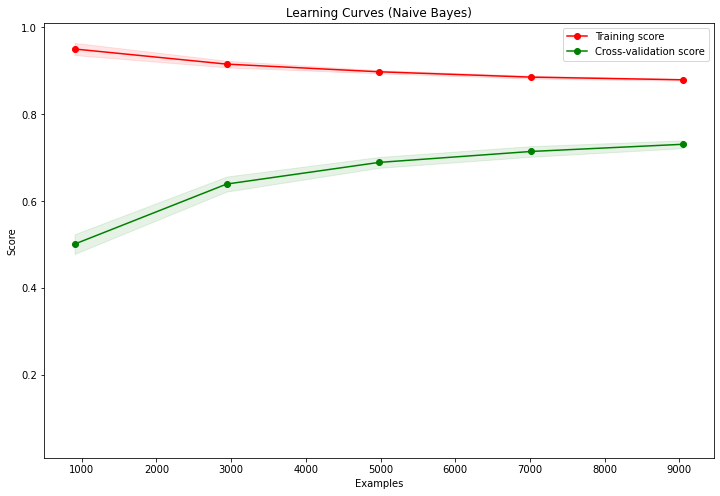

In [13]:
fig, axes = plt.subplots(1,1, figsize=(12, 8))
axes.set_title('Learning Curves (Naive Bayes)')
axes.set_ylim(*(0.01, 1.01))
axes.set_xlabel('Examples')
axes.set_ylabel('Score')
  

# Plot
# axes.grid()
axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes.legend(loc="best")

plt.show()

## Hyper-parameter Optimization

In [10]:
# RandomCV gives us similar results to GridSearch with a percentage of the run time

param_grid = {
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'tfidfvectorizer__binary': [True, False],
    'tfidfvectorizer__norm': [None, 'l1', 'l2'],
    'tfidfvectorizer__max_features': (5000, 10000, 20000,30000,40000,50000, None),
}

pipeline = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())
grid_search = RandomizedSearchCV(pipeline, param_grid, return_train_score=True, verbose=10, n_jobs=-1)

clf_opt = grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  5.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  6.0min remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished


In [14]:
clf_opt.best_params_

{'tfidfvectorizer__norm': None,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__max_features': 50000,
 'tfidfvectorizer__binary': False}

In [12]:
# We use best model to predict and print results  
y_pred = clf_opt.predict(X_test)
print('Per Class Evaluation: \n' + classification_report(y_test,y_pred))

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       319
           1       0.58      0.76      0.66       389
           2       0.67      0.02      0.04       394
           3       0.52      0.74      0.61       392
           4       0.63      0.77      0.70       385
           5       0.79      0.71      0.74       395
           6       0.75      0.73      0.74       390
           7       0.73      0.82      0.77       396
           8       0.81      0.85      0.83       398
           9       0.91      0.88      0.90       397
          10       0.88      0.90      0.89       399
          11       0.83      0.79      0.81       396
          12       0.68      0.61      0.64       393
          13       0.82      0.78      0.80       396
          14       0.79      0.81      0.80       394
          15       0.72      0.83      0.77       398
          16       0.65      0.75      0.70       364
    